<a href="https://colab.research.google.com/github/dyllanesl/AI-EDGE-Project/blob/main/ASL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Restart Runtime
Quick way to restart the runtime

In [ ]:
import os
os._exit(00)



#Install dependencies
Install dependices and necessary libaries

In [2]:
# Install essential libraries
!pip install torch==2.3.0 torchvision==0.18.1
!pip install diffusers transformers datasets accelerate
!pip install mediapipe opencv-python
!pip install diffusers datasets transformers accelerate

# Download the Mediapipe hand landmarker model
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.3.0 and torchvision==0.18.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.3.0
    torchvision 0.18.1 depends on torch==2.3.1

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#deal

#Load Specific pre-trained diffusion model
From hugging Face Model Hub , this provides an easy way to load and interact with pre-trained diffusion models.

In [5]:
import torch
from torch import nn
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
    def __init__(self, model_name, num_classes=26, class_emb_size=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Load the model configuration from the pre-trained model
        self.model = UNet2DModel.from_pretrained(model_name, ignore_mismatched_sizes=True, low_cpu_mem_usage=False)

        # Update the in_channels to include the class embedding size
        self.model.config.in_channels = 3 + class_emb_size

        # Reinitialize the first convolutional layer to match the updated configuration
        old_conv = self.model.conv_in
        self.model.conv_in = nn.Conv2d(
            3 + class_emb_size,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding
        )

        # Initialize the new weights
        with torch.no_grad():
            self.model.conv_in.weight[:, :3, :, :] = old_conv.weight
            if self.model.conv_in.weight.size(1) > 3:
                nn.init.normal_(self.model.conv_in.weight[:, 3:, :, :], 0, 0.02)
            if self.model.conv_in.bias is not None:
                self.model.conv_in.bias = old_conv.bias

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        class_cond = self.class_emb(class_labels).view(bs, -1, 1, 1).expand(bs, -1, w, h)
        net_input = torch.cat((x, class_cond), 1)
        return self.model(net_input, t)

    def save_pretrained(self, save_directory):
        self.model.save_pretrained(save_directory)
        torch.save(self.class_emb.state_dict(), f"{save_directory}/class_emb.pth")

    @classmethod
    def from_pretrained(cls, model_name, save_directory, num_classes=26, class_emb_size=4):
        model = cls(model_name, num_classes, class_emb_size)
        model.model = UNet2DModel.from_pretrained(save_directory, ignore_mismatched_sizes=True, low_cpu_mem_usage=False)

        # Ensure the first convolutional layer is correctly reinitialized
        old_conv = model.model.conv_in
        model.model.conv_in = nn.Conv2d(
            3 + class_emb_size,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding
        )

        # Initialize the new weights
        with torch.no_grad():
            model.model.conv_in.weight[:, :3, :, :] = old_conv.weight
            if model.model.conv_in.weight.size(1) > 3:
                nn.init.normal_(model.model.conv_in.weight[:, 3:, :, :], 0, 0.02)
            if model.model.conv_in.bias is not None:
                model.model.conv_in.bias = old_conv.bias

        model.class_emb.load_state_dict(torch.load(f"{save_directory}/class_emb.pth"))
        return model


In [7]:
model_name = "dyllanesl/ASL_Diffusion_Model"  # Example smaller model
#model_name = "google/ddpm-cifar10-32

# Instantiate the custom class with the pre-trained model configuration
custom_model = ClassConditionedUnet(model_name)

# Move the model to GPU if available
#custom_model.to("cuda")


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Train Model Here
In this cell we upload the csv file to then use to combine with our images then push the final dataset combined to HuggingFace

In [41]:
# Convert the dataset to a pandas DataFrame
# Load the CSV file with labels
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

csv_filename = list(uploaded.keys())[0]

labels_df = pd.read_csv("ASL_Sheet.csv")



Saving ASL_Sheet.csv to ASL_Sheet (1).csv


#Pull images from hugging face
Here we get our images from a current dataset that only has images to prepare to combine with the labels

In [46]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("ascar17/ASLPics")

print(dataset)
print(dataset["train"][0])

Resolving data files:   0%|          | 0/78 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 78
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x300 at 0x7E933B06B490>}


#Testing
Here we see if this was done correctly by trying to display the first image to check if this was successful, while also displaying the label column to further confirm this

In [43]:
#Import io and PIL
from io import BytesIO
from PIL import Image

#Print the first item in the dataset
image = dataset["train"][0]['image']
image

#display
labels_df['label']

0     A
1     A
2     A
3     B
4     B
     ..
73    Y
74    Y
75    Z
76    Z
77    Z
Name: label, Length: 78, dtype: object

#Push to Hugging Face
Here we upload our secret token, must use your own

In [44]:
from google.colab import userdata
from huggingface_hub import login
login(token = userdata.get('ASL_Token'))


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#Install datasets/Combine images and labels
Here we finally combine our images and labels through a dictonary

In [ ]:
!pip install datasets

In [48]:
print(Dataset.from_dict({'image': dataset["train"]['image'], 'label': labels_df['label']})
)

Dataset({
    features: ['image', 'label'],
    num_rows: 78
})


In [45]:
from datasets import Dataset
#combine the images with the labels
image_dataset = Dataset.from_dict({'image': dataset["train"]['image'], 'label': labels_df['label']})
#Display
image_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 78
})

#Final Push to huggingface
Push to hugging face new dataset to save it and have it there :)

In [47]:
#Send it to huggingface
image_dataset.push_to_hub("ascar17/FinalDataAsl")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ascar17/FinalDataAsl/commit/1df4c317589a7c973b5822cc28400f415a30f2d8', commit_message='Upload dataset', commit_description='', oid='1df4c317589a7c973b5822cc28400f415a30f2d8', pr_url=None, pr_revision=None, pr_num=None)

In [49]:
model_name = "google/ddpm-cifar10-32"  # Example smaller model

# Check if a saved model exists
save_directory = "/content/fine_tuned_class_conditioned_unet"
if os.path.exists(save_directory):
    print('WE use a custom model')
    custom_model = ClassConditionedUnet.from_pretrained(model_name, save_directory)
else:
    print('WE use a default model')
    custom_model = ClassConditionedUnet(model_name)

# Move the model to GPU if available
# custom_model.to("cuda")

WE use a custom model


Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

dataset = load_dataset('ascar17/FinalDataAsl')

In [63]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Define preprocessing steps
preprocess = Compose([
    Resize((128, 128)),
    ToTensor(),
    Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def preprocess_function(example):
    try:
        image = example['image']
        image = image.convert("RGB")
        image = preprocess(image)
        label = example['label']
        label = ord(label) - ord('A')
        return {"pixel_values": image, "label": label}
    except Exception as e:
        print(f"Error processing image: {e}")
        return {"pixel_values": None, "label": None}

# Apply the preprocessing function to the dataset
processed_dataset = dataset.map(preprocess_function, remove_columns=["image"])

# Check if 'pixel_values' column exists
print(f"Processed dataset length: {len(processed_dataset['train'])}")

if len(processed_dataset['train']) > 0:
    print(processed_dataset['train'][0])

# Format the dataset for PyTorch if it contains data
if len(processed_dataset['train']) > 0:
    processed_dataset['train'].set_format(type='torch', columns=['pixel_values', 'label'])

    # Inspect the preprocessed dataset
    print(processed_dataset['train'][0])
else:
    print("Processed dataset is empty.")


Processed dataset length: 78
{'label': 0, 'pixel_values': [[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [70]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from accelerate import Accelerator
from torch.cuda.amp import autocast, GradScaler
import torchvision
import torch
import os

output_dir = "/content/generated_images"
os.makedirs(output_dir, exist_ok=True)

# Load the validation dataset
dataset = load_dataset("ascar17/FinalDataAsl", split='train')

# DataLoader for validation data
val_dataloader = DataLoader(processed_dataset, batch_size=1, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

custom_model.to(device)  # Move model to the correct device

custom_model.eval()
# Initialize Accelerator
accelerator = Accelerator()

# Initialize the optimizer
optimizer = AdamW(custom_model.parameters(), lr=1e-6)

# Reduce batch size to minimize memory usage
train_dataloader = DataLoader(processed_dataset['train'], batch_size=1, shuffle=True)

# Prepare the model, optimizer, and dataloader with Accelerator
custom_model, optimizer, train_dataloader = accelerator.prepare(custom_model, optimizer, train_dataloader)

# Number of epochs and accumulation steps
num_epochs = 1
accumulation_steps = 4  # Adjust as necessary for your hardware

for epoch in range(num_epochs):
    custom_model.train()
    epoch_loss = 0
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(custom_model):
            images = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            # Generate noisy images
            noise = torch.randn_like(images).to(device)
            noisy_images = images + noise * 0.05

            # Generate timesteps tensor
            timesteps = torch.randint(0, 999, (images.shape[0],), device=device)

            # Forward pass with mixed precision

            outputs = custom_model(images, t=timesteps, class_labels=labels)
            # Compute loss manually
            loss = torch.nn.functional.mse_loss(outputs.sample, noisy_images) / accumulation_steps  # Scale loss

            # Backward pass
            loss.backward()

            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()

            if step % 10 == 0:
                torchvision.utils.save_image(noisy_images, os.path.join(output_dir, f'noisy_epoch{epoch}_step{step}.png'))
                torchvision.utils.save_image(outputs.sample, os.path.join(output_dir, f'denoised_epoch{epoch}_step{step}.png'))


            # Clear unused variables
            del images, noise, noisy_images, outputs, loss
            torch.cuda.empty_cache()
        #print(f"Batcg {batch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_dataloader)}")
        # Clear cache after each step to free up memory
        torch.cuda.empty_cache()

    # Clear cache after each epoch to free up memory
    torch.cuda.empty_cache()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_dataloader)}")
    # Save the fine-tuned model after each epoch
    custom_model.save_pretrained(save_directory)
# Save the fine-tuned model
custom_model.save_pretrained("fine_tuned_class_conditioned_unet")

Epoch 1/1, Loss: 0.12474572534362476


In [65]:
torch.save(custom_model.class_emb.state_dict(), "fine_tuned_class_conditioned_unet/class_emb.pth")


#Display the noisy/denoisy data
Work on
Take into account label only is taking into account image atm

#Single Image generation
dont run untill above complete



Generated Images: ['denoised_epoch0_step0.png', 'denoised_epoch0_step60.png', 'noisy_epoch0_step20.png', 'denoised_epoch0_step30.png', 'noisy_epoch0_step60.png', 'denoised_epoch0_step10.png', '.ipynb_checkpoints', 'denoised_epoch0_step70.png', 'noisy_epoch0_step50.png', 'noisy_epoch0_step40.png', 'noisy_epoch0_step30.png', 'denoised_epoch0_step20.png', 'noisy_epoch0_step0.png', 'noisy_epoch0_step10.png', 'denoised_epoch0_step50.png', 'noisy_epoch0_step70.png', 'denoised_epoch0_step40.png']


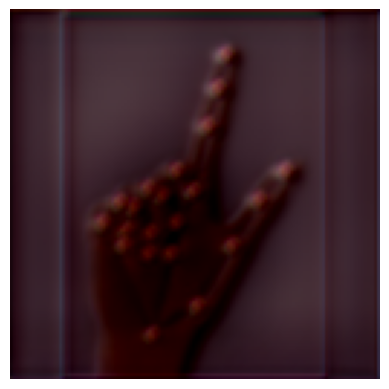

In [71]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing the generated images
output_dir = "/content/generated_images"

# List all files in the directory
generated_images = os.listdir(output_dir)
print("Generated Images:", generated_images)

# Function to display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Display a specific generated image
image_to_display = os.path.join(output_dir, generated_images[0])  # Change index to display a different image
display_image(image_to_display)


Multiple image geneation
dont run ethier atm

IsADirectoryError: [Errno 21] Is a directory: '/content/generated_images/.ipynb_checkpoints'

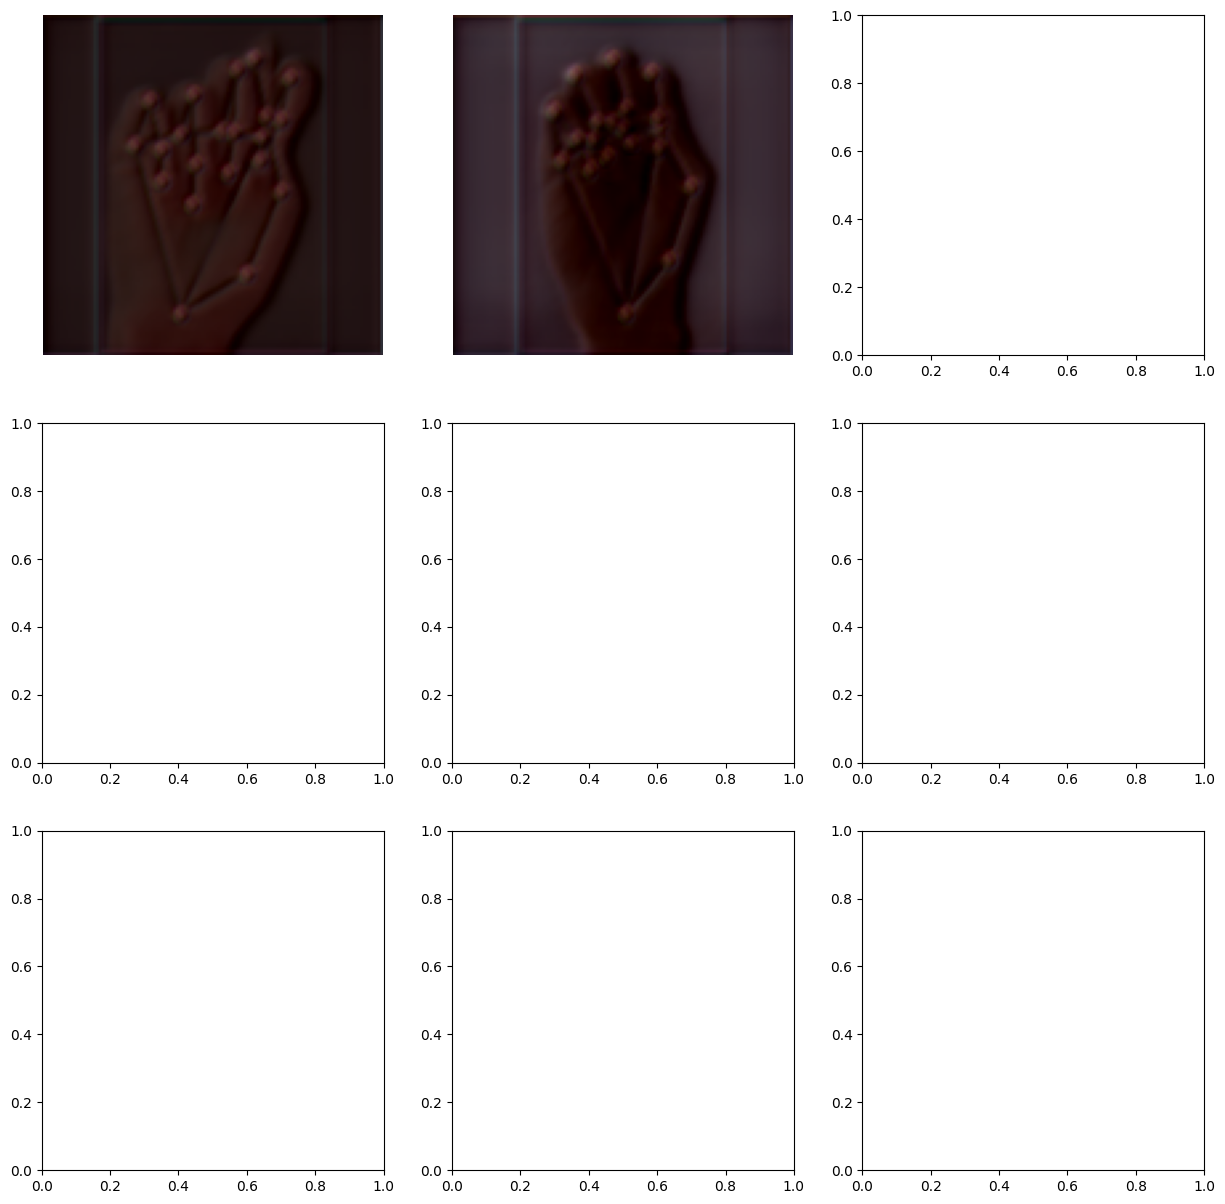

In [67]:
import matplotlib.pyplot as plt

# Display multiple images in a grid
def display_images(image_paths, cols=3, rows=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for ax, img_path in zip(axes.flatten(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get paths for a few generated images
image_paths = [os.path.join(output_dir, img) for img in generated_images[:26]]  # Adjust the number of images as needed
display_images(image_paths)